In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.utils.np_utils import to_categorical 
import librosa
import cv2
import os

In [21]:
# İki adet model oluşturuldu. 1.Model Doğrudan elde edilen spektrogramlarla eğitildi - 2.Model ise diğer notebook üzerinden
# elde edilen spektogram görüntüleri sayısal değerlere dönüştürülerek eğitildi.
# doğrudan spektogram verileri ile eğitilen model, spektogram -> görüntü -> numy.array dönüşümü işlemlerinden 
# elde edilen veri ile eğitilen modele göre
# %10 daha başarılı sonuçlar ürettmiştir (epoch = 20,batchsize = 250 değer ataması durumunda)

In [ ]:
!pip install librosa
!pip install opencv-python
!pip install tensorflow
!pip install keras

In [23]:
spectrogram = []
data = []

data1 = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
y1 = data1["classID"]


In [24]:
data1.shape

(8732, 8)

In [5]:
path = "UrbanSound8K/audio/"
dim = (64,64)
for x in range(0,len(data1)):
    new_path = path+"fold"+data1.iloc[x,5].astype(str)+"/"+data1.iloc[x,0]
    file_name = data1.iloc[x,0]
    file_name = file_name[:-4].strip().replace(" ","")
     
    y,sr = librosa.load(new_path)
    spec = librosa.feature.melspectrogram(y=y,sr=sr)
    specDB= librosa.amplitude_to_db(spec,ref= np.max)
    resized_specDB = cv2.resize(specDB,dim, interpolation = cv2.INTER_AREA)
    spectrogram.append(resized_specDB)
                        
spectrogram = np.array(spectrogram)

C:\Users\Begy\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\Users\Begy\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Begy\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [6]:
spectrogram.shape

(8732, 64, 64)

In [25]:
y2 = []
foldNumber = 0
for folder in os.listdir('folders'):
    for image in os.listdir('folders/'+folder):
        img = Image.open('folders/'+folder+'/'+image)
        img = img.resize((64,64))
        img_s = img.getdata()
        img_m = np.array(img_s)
        img_m = img_m/255
        data.append(img_m)
        y2.append(foldNumber) 
    foldNumber=foldNumber+1  

y1 = np.array(y1)    

In [28]:
data = np.array(data).reshape(-1,64,64,1)
y2 = np.array(y2) 
from sklearn.model_selection import train_test_split

In [29]:
data.shape

(8732, 64, 64, 1)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(spectrogram, y1, test_size=0.33, random_state=42)
y_one_hot =  to_categorical(y_train, num_classes = 10)
y_t_one_hot = to_categorical(y_test, num_classes = 10)

In [18]:

model = Sequential()
    
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64,64,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])   


Epoch 1/20
24/24 [==============================] - 71s 3s/step - loss: 2.6045 - accuracy: 0.1135 - val_loss: 2.2751 - val_accuracy: 0.1096
Epoch 2/20
24/24 [==============================] - 66s 3s/step - loss: 2.2278 - accuracy: 0.1509 - val_loss: 2.0665 - val_accuracy: 0.2776
Epoch 3/20
24/24 [==============================] - 72s 3s/step - loss: 1.9893 - accuracy: 0.2819 - val_loss: 1.6804 - val_accuracy: 0.4493
Epoch 4/20
24/24 [==============================] - 80s 3s/step - loss: 1.5891 - accuracy: 0.4427 - val_loss: 1.4032 - val_accuracy: 0.4972
Epoch 5/20
24/24 [==============================] - 74s 3s/step - loss: 1.3384 - accuracy: 0.5311 - val_loss: 1.2922 - val_accuracy: 0.5524
Epoch 6/20
24/24 [==============================] - 71s 3s/step - loss: 1.2200 - accuracy: 0.5696 - val_loss: 1.1558 - val_accuracy: 0.5874
Epoch 7/20
24/24 [==============================] - 70s 3s/step - loss: 1.1505 - accuracy: 0.6017 - val_loss: 1.2020 - val_accuracy: 0.5680
Epoch 8/20
24/24 [==

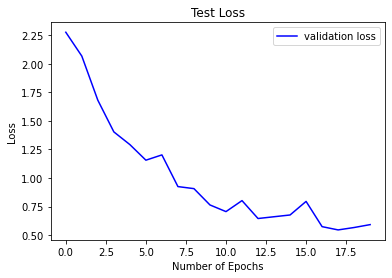

In [19]:
history = model.fit(X_train,y_one_hot, batch_size=250, epochs=20,validation_data=(X_test, y_t_one_hot))
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data, y2, test_size=0.33, random_state=42)
y_one_hot2 =  to_categorical(y_train2, num_classes = 10)
y_t_one_hot2 = to_categorical(y_test2, num_classes = 10)

In [33]:
model2 = Sequential()
    
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64,64,1)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
    
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])   

Epoch 1/20
24/24 [==============================] - 66s 3s/step - loss: 2.2619 - accuracy: 0.1217 - val_loss: 2.2452 - val_accuracy: 0.1648
Epoch 2/20
24/24 [==============================] - 62s 3s/step - loss: 2.1746 - accuracy: 0.1754 - val_loss: 2.1869 - val_accuracy: 0.1728
Epoch 3/20
24/24 [==============================] - 63s 3s/step - loss: 2.0859 - accuracy: 0.2292 - val_loss: 2.0561 - val_accuracy: 0.2550
Epoch 4/20
24/24 [==============================] - 58s 2s/step - loss: 1.9874 - accuracy: 0.2590 - val_loss: 1.9645 - val_accuracy: 0.2713
Epoch 5/20
24/24 [==============================] - 56s 2s/step - loss: 1.8817 - accuracy: 0.2991 - val_loss: 1.8357 - val_accuracy: 0.3362
Epoch 6/20
24/24 [==============================] - 57s 2s/step - loss: 1.7147 - accuracy: 0.3571 - val_loss: 1.5885 - val_accuracy: 0.4084
Epoch 7/20
24/24 [==============================] - 56s 2s/step - loss: 1.5796 - accuracy: 0.4197 - val_loss: 1.4505 - val_accuracy: 0.4840
Epoch 8/20
24/24 [==

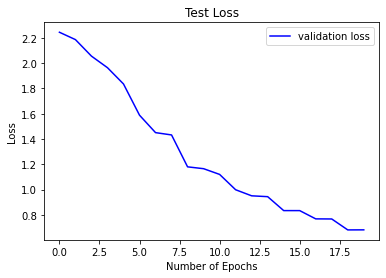

In [34]:
history2 = model2.fit(X_train2,y_one_hot2, batch_size=250, epochs=20,validation_data=(X_test2, y_t_one_hot2))

plt.plot(history2.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()